In [1]:
%load_ext autoreload

In [2]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from mlxtend.plotting import plot_confusion_matrix

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as T
from torchvision import models
from torch.optim import lr_scheduler
from torch.utils.data import Dataset, Subset
from torch.utils.data import DataLoader
from torch.utils.data.dataloader import default_collate
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision.models import resnet18
from torchvision.io import read_image
from torch.optim import Adam
from torchsummary import summary

In [3]:
%autoreload 2
from utils.datasets import STL10_Dataset, OCT_2D_Dataset
from utils.general import imshow

In [4]:
hparams = {
    "epochs": 10000, # number of training epochs
    "seed": 77777, # randomness seed
    "cuda": True, # use nvidia gpu
    "img_size": 224, #image shape
    "save": "./saved_models/", # save checkpoint
    "load": False, # load pretrained checkpoint
    "gradient_accumulation_steps": 5, # gradient accumulation steps
    "batch_size": 8,
    "n_views": 2,
    "lr": 3e-4, # for ADAm only
    "weight_decay": 1e-6,
    "embedding_size": 128, # papers value is 128
    "temperature": 0.07, # 0.07 (MOCO) or 0.5 (SimCLR)
    "log_frequency": 100,
    "checkpoint_path": './SimCLR_ResNet18.ckpt' # replace checkpoint path here
}

In [5]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
torch.manual_seed(hparams['seed'])
torch.cuda.manual_seed(hparams['seed'])
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(hparams['seed'])

# Data Setup

In [7]:
transform = T.Compose([
    lambda x: x.squeeze().repeat(3, 1, 1),
    T.Resize((hparams['img_size'], hparams['img_size']), antialias=True),
    lambda x: x / 255,
    T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

stl_dir = '/home/ludwig-graef/Workplace/12.Semester/Master_Thesis/datasets/STL10'
# stl_dataset = STL10_Dataset(stl_dir, target_transform=target_transform)

oct_dir = '/home/ludwig-graef/Workplace/12.Semester/Master_Thesis/datasets/oct_kaggle_1/OCT2017'
oct_2d_dataset = OCT_2D_Dataset(oct_dir, read_image, '.jpeg', transform)

dataset = oct_2d_dataset

In [8]:
indices = list(range(len(dataset)))
np.random.shuffle(indices)
split = int(np.floor(0.2 * len(dataset)))
train_indices, val_indices = indices[split:], indices[:split]   

train_sampler = SubsetRandomSampler(train_indices)
validation_sampler = SubsetRandomSampler(val_indices)

train_dataloader = DataLoader(dataset, batch_size=hparams['batch_size'], sampler=train_sampler)
validation_dataloader = DataLoader(dataset, batch_size=hparams['batch_size'], sampler=validation_sampler)

classes = dataset.classes
classes

['CNV', 'DME', 'DRUSEN', 'NORMAL']

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


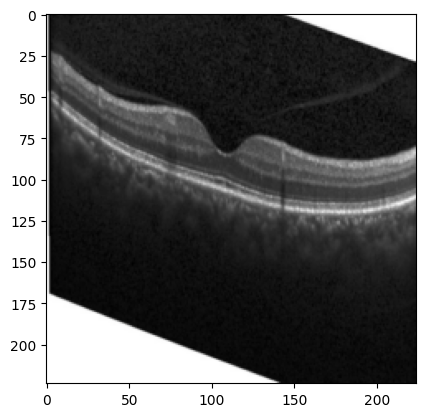

In [9]:
imshow(next(iter(train_dataloader))[0][0])

# Model Setup

In [20]:
class Augment:
    def __init__(self, img_size):
        color_jitter = T.ColorJitter(
            0.8 * 1, 0.8 * 1, 0.8 * 1, 0.2 * 1
        )
        # 10% of the image
        blur = T.GaussianBlur((3, 3), (0.1, 2.0))

        self.train_transform = nn.Sequential(
            T.RandomResizedCrop(size=img_size, antialias=None),
            T.RandomHorizontalFlip(p=0.5),  # with 0.5 probability
        )

    def __call__(self, x):
        return self.train_transform(x)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


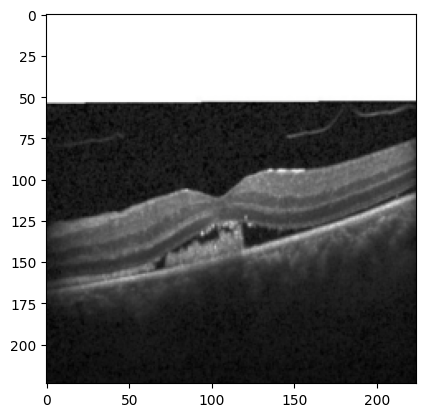

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


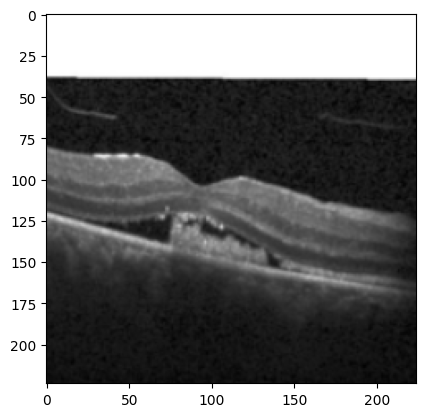

In [21]:
img = dataset[np.random.choice(len(dataset))][0]
augment = Augment(hparams['img_size'])
imshow(img)
imshow(augment(img))

In [22]:
class AddProjection(nn.Module):
    def __init__(self, hparams, backbone=None, mlp_dim=512):
        super(AddProjection, self).__init__()
        embedding_size = hparams['embedding_size']
        self.backbone = backbone or models.resnet18(weights='ResNet18_Weights.DEFAULT', num_classes=embedding_size)
        mlp_dim = mlp_dim or self.backbone.fc.in_features

        for param in self.backbone.parameters():
            param.requires_grad = False

        print('Dim MLP input:', mlp_dim)
        self.backbone.fc = nn.Identity()

        # add mlp projection head
        self.projection = nn.Sequential(
           nn.Linear(in_features=mlp_dim, out_features=mlp_dim),
           nn.BatchNorm1d(mlp_dim),
           nn.ReLU(),
           nn.Linear(in_features=mlp_dim, out_features=embedding_size),
           nn.BatchNorm1d(embedding_size),
       )

    def forward(self, x, return_embedding=False):
        with torch.no_grad():
            embedding = self.backbone(x)
        if return_embedding:
            return embedding
        return self.projection(embedding)

In [33]:
from pytorch_metric_learning import losses

class SimCLR_pl(nn.Module):
    def __init__(self, hparams: dict, backbone=None, feat_dim=512):
        super().__init__()
        self.config = hparams
        self.augment = Augment(hparams['img_size'])
        self.model = AddProjection(hparams, backbone=backbone, mlp_dim=feat_dim)

        self.loss = losses.NTXentLoss(temperature=hparams['temperature'])

    def forward(self, X):
        return self.model(X)

    def training_step(self, batch, batch_idx):
        imgs, labels = batch
        embeddings = [self.model(self.augment(imgs)) for _ in range(self.config['n_views'])]
        indices = torch.Tensor([ii for _ in range(self.config['n_views']) for ii in range(len(imgs))])
        loss = self.loss(torch.cat(embeddings), indices)
        return loss

    def configure_optimizers(self):
        # param_groups = define_param_groups(self.model, self.config['weight_decay'], 'adam')
        optimizer = Adam(self.model.projection.parameters(), lr=self.config['lr'], weight_decay=self.config['weight_decay'])

        scheduler_warmup = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, 10, 1, self.config['epochs'])

        return optimizer, scheduler_warmup

# Running model


In [34]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f'Device: {device}')

backbone = resnet18(weights='ResNet18_Weights.DEFAULT')
model = SimCLR_pl(hparams, backbone, feat_dim=512).to(device)
summary(model, (3, hparams['img_size'], hparams['img_size']))
optimizer, scheduler = model.configure_optimizers()

train_dataloader.collate_fn = lambda x: tuple(x_.to(device) for x_ in default_collate(x))

with tqdm(total=hparams['epochs']) as pbar:
    for epoch in range(hparams['epochs']):
        model.train()

        total_loss = 0.0

        optimizer.zero_grad()
        for batch_idx, (batch, target) in enumerate(train_dataloader):
            loss = model.training_step((batch, target), batch_idx)

            loss.backward()
            
            total_loss += loss.item()

        # Accumulate gradients and update after processing all batches
        optimizer.step()
        # scheduler.step()

        average_loss = total_loss / len(train_dataloader)

        if epoch % hparams['log_frequency'] == 0:
            pbar.set_postfix({'Loss': f'{average_loss:.4f}'})
            pbar.update(epoch - pbar.n)
        

Device: cuda:0
Dim MLP input: 512
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
     

  0%|          | 0/10000 [00:32<?, ?it/s]


KeyboardInterrupt: 

In [ ]:
torch.cuda.empty_cache()

# Graphs


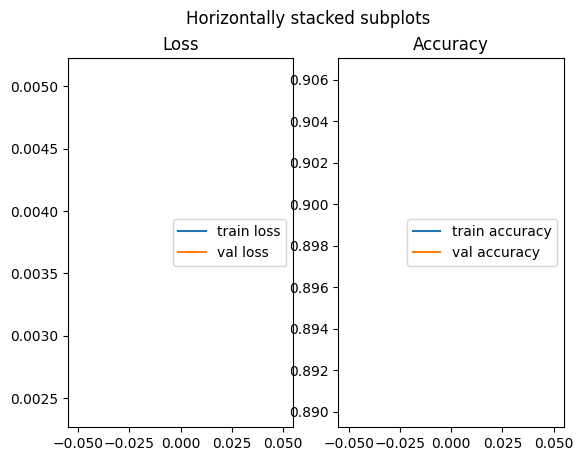

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle('Horizontally stacked subplots')
ax1.plot(train_loss, label='train loss')
ax1.plot(val_loss, label='val loss')
ax1.legend()
ax1.set_title('Loss')
ax2.plot(train_acc, label='train accuracy')
ax2.plot(val_acc, label='val accuracy')
ax2.set_title('Accuracy')
ax2.legend()

# Test accuracy using model with lowest val accuracy


In [ ]:
running_loss = 0.0
running_correct = 0
model.eval()
# Iterate over batches
for inputs, labels in tqdm(test_dataloader):
    inputs = inputs.to(device)
    labels = labels.to(device)

    with torch.set_grad_enabled(False):
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)

    running_loss += loss.item() * inputs.size(0)
    running_correct += torch.sum(preds == labels.data)

epoch_loss = running_loss / test_len
epoch_acc = running_correct.double() / test_len

print('{} loss: {:4f} acc: {:4f}'.format('test', epoch_loss, epoch_acc))

# Other Metrics


In [ ]:
from sklearn.metrics import confusion_matrix


def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds)), preds


def validation_step(batch, model):
    images, labels = batch
    images, labels = images.to(device), labels.to(device)
    out = model(images)
    loss = F.cross_entropy(out, labels)
    acc, preds = accuracy(out, labels)

    return {'val_loss': loss.detach(), 'val_acc': acc.detach(), 'preds': preds.detach(), 'labels': labels.detach()}


def test_prediction(outputs):
    batch_losses = [x['val_loss'] for x in outputs]
    epoch_loss = torch.stack(batch_losses).mean()
    batch_accs = [x['val_acc'] for x in outputs]
    epoch_acc = torch.stack(batch_accs).mean()
    # combine predictions
    batch_preds = torch.cat([x['preds'] for x in outputs])
    # combine labels
    batch_labels = torch.cat([x['labels'] for x in outputs])

    return {
        'test_loss': epoch_loss.item(),
        'test_acc': epoch_acc.item(),
        'test_preds': batch_preds.tolist(),
        'test_labels': batch_labels.tolist()
    }


@torch.no_grad()
def test_predict(model, test_loader):
    model.eval()
    # perform testing for each batch
    outputs = [validation_step(batch, model) for batch in tqdm(test_loader)]
    results = test_prediction(outputs)
    print('test_loss: {:.4f}, test_acc: {:.4f}'.format(results['test_loss'], results['test_acc']))

    return results['test_preds'], results['test_labels']


# Plot confusion matrix
def plot_cm(labels, preds, classes, title=''):
    cm = confusion_matrix(labels, preds, labels=list(range(len(classes))))

    plt.figure()
    plot_confusion_matrix(cm, figsize=(12, 8), cmap=plt.cm.Blues)
    plt.xticks(range(len(classes)), classes, fontsize=16)
    plt.yticks(range(len(classes)), classes, fontsize=16)
    plt.xlabel('Predicted Label', fontsize=18)
    plt.ylabel('True Label', fontsize=18)
    plt.title(title, fontsize=24)
    plt.show()

    return cm


def calculate_metrics(cm, preds, labels, classes):
    # Compute Performance Metrics
    accuracy = (np.array(preds) == np.array(labels)).sum() / len(preds)
    precision = np.diag(cm) / cm.sum(axis=0)
    recall = np.diag(cm) / cm.sum(axis=1)
    f1 = 2 * (precision * recall) / (precision + recall)

    print("Accuracy of the model is {:.2f}".format(accuracy))
    for i, class_name in enumerate(classes):
        print("Precision of {} class is {:.2f}".format(class_name, precision[i]))
        print("Recall of {} class is {:.2f}".format(class_name, recall[i]))
        print("F1 Score of {} class is {:.2f}".format(class_name, f1[i]))


In [ ]:
preds, labels = test_predict(model, test_dataloader)

In [ ]:
cm_custom = plot_cm(labels, preds, classes, title='Confusion Matrix for Supervised classification')

In [ ]:
print("For supervised classification:")
calculate_metrics(cm_custom, preds, labels, classes)